In [6]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
from steam import WebAPI
from datetime import datetime
import os
import glob
import json
import tensorflow as tf
import sys
from IPython import display
import requests
import tensorflow.keras.backend as K
from sklearn import decomposition

#import logging
#logging.getLogger("tensorflow").setLevel(logging.ERROR)

#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

print(tf.__version__)

2.1.0


In [7]:
sns.set_style('ticks')

In [8]:
champfile=os.path.join('lol_data','version9.10.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
hero_vocab = [int(i) for i in champ_vocab]
print(len(hero_vocab))

144


# Build TFRecord input pipeline

In [9]:
def _parse_function_extra_info(example_proto):
    """Extracts features and labels.
  
    Args:
        example_proto: tf.Example protocol (unsure what this is)    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A tensor with the corresponding labels.
    """
    features = {}
    #there are 5 heroes per team 
    heroes_per_team=5
    #there are 4 pieces of info for a hero in LOL
    num_info_fields=4
    num_tags=6 #6 tags
    num_valid_stats=14 #14 valid stats (after removing mana and crit)
    #loop through five times to capture each hero on each team
    for i in range(heroes_per_team):
        #64 bit int for hero
        features["radiant_hero"+str(i)]=tf.io.FixedLenFeature(1, dtype=tf.int64)

        features["radiant_hero_info"+str(i)]=tf.io.FixedLenFeature(num_info_fields,
                                                                   dtype=tf.float32) 
        features["radiant_hero_tags"+str(i)] =tf.io.FixedLenFeature(num_tags,
                                                                    dtype=tf.int64) 
        features["radiant_hero_stats"+str(i)] =tf.io.FixedLenFeature(num_valid_stats,
                                                                     dtype=tf.float32) 
        
        features["dire_hero"+str(i)] =tf.io.FixedLenFeature(1, dtype=tf.int64) 
        features["dire_hero_info"+str(i)] =tf.io.FixedLenFeature(num_info_fields,
                                                                 dtype=tf.float32) 
        features["dire_hero_tags"+str(i)] =tf.io.FixedLenFeature(num_tags,
                                                                 dtype=tf.int64) 
        features["dire_hero_stats"+str(i)] =tf.io.FixedLenFeature(num_valid_stats,
                                                                  dtype=tf.float32) 
 
    #there are 11 different regions (at least in my most current dataset)
    num_regions=11
    #two skill levels in the lol api
    num_skill_levels=2
    #get num_heroes from hero_vocab
    num_heroes=len(hero_vocab)

    features["region"] = tf.io.FixedLenFeature(num_regions, dtype=tf.int64)
    features["skill_level"] = tf.io.FixedLenFeature(1, dtype=tf.int64)
    
    features["targets"] = tf.io.FixedLenFeature(1, dtype=tf.int64)
    
    #parse features
    parsed_features = tf.io.parse_single_example(example_proto, features)
    
    #load parsed features into dict of features and targets
    feature_dict={}
    for i in range(heroes_per_team):
        feature_dict['radiant_hero'+str(i)]=tf.one_hot(parsed_features['radiant_hero'+str(i)],
                                                    num_heroes)
        feature_dict['radiant_hero_info'+str(i)]=parsed_features['radiant_hero_info'+str(i)]
        feature_dict['radiant_hero_tags'+str(i)]=parsed_features['radiant_hero_tags'+str(i)]
        feature_dict['radiant_hero_stats'+str(i)]=parsed_features['radiant_hero_stats'+str(i)]
        feature_dict['dire_hero'+str(i)]=tf.one_hot(parsed_features['dire_hero'+str(i)],
                                                 num_heroes)
        feature_dict['dire_hero_info'+str(i)]=parsed_features['dire_hero_info'+str(i)]
        feature_dict['dire_hero_tags'+str(i)]=parsed_features['dire_hero_tags'+str(i)]
        feature_dict['dire_hero_stats'+str(i)]=parsed_features['dire_hero_stats'+str(i)]

    feature_dict['region'] = parsed_features['region']
    feature_dict['skill_level']= tf.one_hot(parsed_features['skill_level'],
                                            num_skill_levels)
    target = parsed_features['targets']
    
    return feature_dict, target

#### Check the parse function worked

In [10]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data',
                                          'mix_tier',
                                          'lol_training_data',
                                          'blue_win_extra_info_dota2_compat_lol_training_data.tfrecords'),
                                          compression_type="GZIP")
# Map features and labels with the parse function.
ds = ds.map(_parse_function_extra_info)

In [11]:
ds = ds.shuffle(10000)
print(next(iter(ds)))

({'radiant_hero0': <tf.Tensor: shape=(1, 144), dtype=float32, numpy=
array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)>, 'radiant_hero_info0': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 0.18409063, -1.32853   ,  0.20679489,  1.6020833 ], dtype=float32)>, 'radiant_hero_tags0': <tf.Tensor: shape=(6,), dtype=int64, numpy=array([0, 0, 1, 0, 0, 0])>, 'radiant_hero_stats0'

## Input functions

In [12]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn_extra_info(input_filenames, num_epochs=None, 
              shuffle=True, batch_size=50,compression_type=""):
   
   # Same code as above; create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames,compression_type=compression_type)
    ds = ds.map(_parse_function_extra_info)

    if shuffle:
        ds = ds.shuffle(10000)
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    # Return the dataset.
    return ds

# Define and train the models

## various iterations of linear models

### linear models (with and without extra info)

In [52]:
#define the linear model with no feature columns
def define_linear_model_hero_only(vocab_len,
                                   embedding_dims):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `list` of `int` specifying the number of dimensions in
            the embedding layer
    Returns:
        model: A uncompiled `tf.keras.model`
    '''
    
    ##define hero processing layers
    #embed hero with dense because shared embedding layers are broken
    dense_hero = tf.keras.layers.Dense(embedding_dims,activation='linear')
    
    hero_input=[]
    rad_hero_output=[]
    dire_hero_output=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='radiant_hero'+str(i)))
        x_rh = dense_hero(hero_input[-1])        
        x_rh = tf.keras.layers.Flatten()(x_rh)
        #append radiant outputs for summing
        rad_hero_output.append(x_rh)
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='dire_hero'+str(i)))
        x_dh = dense_hero(hero_input[-1])
        x_dh = tf.keras.layers.Flatten()(x_dh)
        #append dire outputs for summing
        dire_hero_output.append(x_dh)
    #sum hero outputs to erase ordering information and get ave team vector
    rad_hero_sum = tf.keras.layers.Add()(rad_hero_output)
    rad_hero_sum = tf.keras.layers.Flatten()(rad_hero_sum)
    dire_hero_sum = tf.keras.layers.Add()(dire_hero_output)
    dire_hero_sum = tf.keras.layers.Flatten()(dire_hero_sum)
    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)
    
    #define region input layer
    region = tf.keras.Input(shape=(11,),name='region')
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([rad_hero_sum,dire_hero_sum,x_skill,region])
    
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[hero_input,skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=False)
    #model.summary()
    return model

In [43]:
#define the linear model with no feature columns
def define_linear_model_hero_only_ordermatters(vocab_len):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `list` of `int` specifying the number of dimensions in
            the embedding layer
    Returns:
        model: A uncompiled `tf.keras.model`
    '''
    
    rad_hero_input=[]
    dire_hero_input=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        rad_hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='radiant_hero'+str(i)))
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        dire_hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='dire_hero'+str(i)))
    x_rh = tf.keras.layers.concatenate(rad_hero_input)
    x_rh = tf.keras.layers.Flatten()(x_rh)
    
    x_dh = tf.keras.layers.concatenate(dire_hero_input)
    x_dh = tf.keras.layers.Flatten()(x_dh)

    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)
    
    #define region input layer
    region = tf.keras.Input(shape=(11,),name='region')
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([x_rh,x_dh,x_skill,region])
    
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[rad_hero_input,dire_hero_input,
                                   skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=False)
    model.summary()
    return model

In [15]:
#define the linear model with no feature columns
def define_linear_model_extra_info(vocab_len,
                                   embedding_dims):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `list` of `int`s specifying the number of dimensions
            in the input layers
    Returns:
        model: A uncompiled `tf.keras.model`
    '''
    
    ##DEFINE HERO PROCESSING LAYERS
    #embed hero with dense because shared embedding layers are broken
    dense_hero = tf.keras.layers.Dense(embedding_dims[0],activation='linear')
    #process info into num of values specified by dense outputs value
    dense_hero_info = tf.keras.layers.Dense(embedding_dims[1],activation='linear')
    #process tags into num of values specified by dense outputs value
    dense_hero_tags = tf.keras.layers.Dense(embedding_dims[2],activation='linear')
    #process stats into num of values specified by dense outputs value
    dense_hero_stats = tf.keras.layers.Dense(embedding_dims[3],activation='linear')

    #process hero embed, dense_tags, and dense_info output into num of outputs 
    #    half of total embedding dims
    
    dense_hero_total = tf.keras.layers.Dense(sum(embedding_dims)/2,activation='linear')
    
    hero_input=[]
    rad_hero_output=[]
    dire_hero_output=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='radiant_hero'+str(i)))
        x_rh = dense_hero(hero_input[-1])        
        x_rh = tf.keras.layers.Flatten()(x_rh)
        #add radiant hero info to hero_input list and process with
        #    dense_info layer
        hero_input.append(tf.keras.Input(shape=(4,), #4 info types
                                         name='radiant_hero_info'+str(i)))
        x_rhi = dense_hero_info(hero_input[-1])
        #add radiant hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,), #6 tag types
                                         name='radiant_hero_tags'+str(i)))
        x_rht = dense_hero_tags(hero_input[-1])        
        #add radiant hero stats to hero_input list and process with
        #    dense_stats layer
        hero_input.append(tf.keras.Input(shape=(14,), #14 stat types
                                         name='radiant_hero_stats'+str(i)))
        x_rhs = dense_hero_stats(hero_input[-1])
        #append output of hero layers to rad_out_layer for summing later
        x_rhtot = tf.keras.layers.concatenate([x_rh,x_rhi,x_rht,x_rhs])
        rad_hero_output.append(dense_hero_total(x_rhtot))
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='dire_hero'+str(i)))
        x_dh = dense_hero(hero_input[-1])
        x_dh = tf.keras.layers.Flatten()(x_dh)
        #add dire hero info to hero_input list and process with
        #    dense_info layer       
        hero_input.append(tf.keras.Input(shape=(4,),#4 info types
                                         name='dire_hero_info'+str(i)))
        x_dhi = dense_hero_info(hero_input[-1])
        #add dire hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,),#6 tag types
                                         name='dire_hero_tags'+str(i)))
        x_dht = dense_hero_tags(hero_input[-1])
        #add dire hero stats to hero_input list and process with
        #    dense_stats layer
        hero_input.append(tf.keras.Input(shape=(14,), #14 stat types
                                         name='dire_hero_stats'+str(i)))
        x_dhs = dense_hero_stats(hero_input[-1])
        #append output of hero layers to dire_out layer for summing later
        x_dhtot = tf.keras.layers.concatenate([x_dh,x_dhi,x_dht,x_dhs])
        dire_hero_output.append(dense_hero_total(x_dhtot))
    #sum hero outputs to erase ordering information and get ave team vector
    rad_hero_sum = tf.keras.layers.Add()(rad_hero_output)
    dire_hero_sum = tf.keras.layers.Add()(dire_hero_output)    
    
    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)
    x_skill = tf.keras.layers.Dense(1,activation='linear')(x_skill)
    
    #define region input layer
    region = tf.keras.Input(shape=(11,),name='region')
    x_region = tf.keras.layers.Dense(1,activation='linear')(region)
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([rad_hero_sum,dire_hero_sum,x_skill,x_region])
    
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[hero_input,skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=True)
    #model.summary()
    return model

### dnn models (with and without extra info)

In [16]:
#define the linear model with no feature columns
def define_dnn_model_hero_only(vocab_len,
                                embedding_dims,
                                hidden_units_heroes,
                                hidden_units_out):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the 
            categorical input
        embedding_dims: An `list` of `int` specifying the number of dimensions in 
            the embedding layer
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in hero input layer
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in output layer
    Returns: 
        model: A uncompiled `tf.keras.model`
    '''
    
    ##DEFINE HERO PROCESSING LAYER
    #embed hero with dense because shared embedding layers are broken
    dense_hero = tf.keras.layers.Dense(embedding_dims,activation='linear')
    
    #define hero output NN layers
    dense_hero_out_list = []
    for unit in hidden_units_heroes:
        dense_hero_out_list.append(tf.keras.layers.Dense(unit,
                                                         activation='relu'))
    
    hero_input=[]
    rad_hero_output=[]
    dire_hero_output=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='radiant_hero'+str(i)))
        x_rh = dense_hero(hero_input[-1])        
        x_rhtot = tf.keras.layers.Flatten()(x_rh)

        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_rhtot=layer(x_rhtot)
        #append to rad_hero_output list
        rad_hero_output.append(x_rhtot)
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='dire_hero'+str(i)))
        x_dh = dense_hero(hero_input[-1])
        x_dhtot = tf.keras.layers.Flatten()(x_dh)

        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_dhtot=layer(x_dhtot)
        dire_hero_output.append(x_dhtot)
    
    #sum hero outputs to erase ordering information and get ave team vector
    rad_hero_sum = tf.keras.layers.Add()(rad_hero_output)
    dire_hero_sum = tf.keras.layers.Add()(dire_hero_output)    
    
    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)
    region = tf.keras.Input(shape=(11,),name='region')
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([rad_hero_sum,dire_hero_sum,x_skill,region])
    for unit in hidden_units_out:
        x = tf.keras.layers.Dense(unit,activation='relu')(x)
        
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[hero_input,skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=False)
    #model.summary()
    return model

In [17]:
#define the linear model with no feature columns
def define_dnn_model_info_tags(vocab_len,
                                embedding_dims,
                                hidden_units_heroes,
                                hidden_units_out):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the 
            categorical input
        embedding_dims: An `list` of `int` specifying the number of dimensions in 
            the embedding layer
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in hero input layer
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in output layer
    Returns: 
        model: A uncompiled `tf.keras.model`
    '''
    
    ##DEFINE HERO PROCESSING LAYERS
    #embed hero with dense because shared embedding layers are broken
    dense_hero = tf.keras.layers.Dense(embedding_dims[0],activation='linear')
    #process info into num of values specified by dense outputs value
    dense_hero_info = tf.keras.layers.Dense(embedding_dims[1],activation='linear')
    #process tags into num of values specified by dense outputs value
    dense_hero_tags = tf.keras.layers.Dense(embedding_dims[2],activation='linear')
    #process hero embed, dense_tags, and dense_info output into some num of outputs
    dense_hero_out_list = []
    for unit in hidden_units_heroes:
        dense_hero_out_list.append(tf.keras.layers.Dense(unit,
                                                         activation='relu'))
    
    hero_input=[]
    rad_hero_output=[]
    dire_hero_output=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='radiant_hero'+str(i)))
        x_rh = dense_hero(hero_input[-1])        
        x_rh = tf.keras.layers.Flatten()(x_rh)
        #add radiant hero info to hero_input list and process with
        #    dense_info layer
        hero_input.append(tf.keras.Input(shape=(4,), #4 info types
                                         name='radiant_hero_info'+str(i)))
        x_rhi = dense_hero_info(hero_input[-1])
        #add radiant hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,), #6 tag types
                                         name='radiant_hero_tags'+str(i)))
        x_rht = dense_hero_tags(hero_input[-1])        
        #append output of hero layers to rad_out_layer for summing later
        x_rhtot = tf.keras.layers.concatenate([x_rh,x_rhi,x_rht])
        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_rhtot=layer(x_rhtot)
        #append to rad_hero_output list
        rad_hero_output.append(x_rhtot)
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='dire_hero'+str(i)))
        x_dh = dense_hero(hero_input[-1])
        x_dh = tf.keras.layers.Flatten()(x_dh)
        #add dire hero info to hero_input list and process with
        #    dense_info layer       
        hero_input.append(tf.keras.Input(shape=(4,),#4 info types
                                         name='dire_hero_info'+str(i)))
        x_dhi = dense_hero_info(hero_input[-1])
        #add dire hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,),#6 tag types
                                         name='dire_hero_tags'+str(i)))
        x_dht = dense_hero_tags(hero_input[-1])
        #append output of hero layers to dire_out layer for summing later
        x_dhtot = tf.keras.layers.concatenate([x_dh,x_dhi,x_dht])
        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_dhtot=layer(x_dhtot)
        dire_hero_output.append(x_dhtot)
    
    #sum hero outputs to erase ordering information and get ave team vector
    rad_hero_sum = tf.keras.layers.Add()(rad_hero_output)
    dire_hero_sum = tf.keras.layers.Add()(dire_hero_output)    
    
    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)

    region = tf.keras.Input(shape=(11,),name='region')
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([rad_hero_sum,dire_hero_sum,x_skill,region])
    for unit in hidden_units_out:
        x = tf.keras.layers.Dense(unit,activation='relu')(x)
        
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[hero_input,skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=False)
    #model.summary()
    return model

In [18]:
#define the linear model with no feature columns
def define_dnn_model_extra_info(vocab_len,
                                embedding_dims,
                                hidden_units_heroes,
                                hidden_units_out):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the 
            categorical input
        embedding_dims: An `list` of `int` specifying the numbers of dimensions in 
            the embedding layers
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in hero input layer
        hidden_units_heroes: A `list` specifying size and number of hidden 
            units in output layer
    Returns: 
        model: A uncompiled `tf.keras.model`
    '''
    
    ##DEFINE HERO PROCESSING LAYERS
    #embed hero with dense because shared embedding layers are broken
    dense_hero = tf.keras.layers.Dense(embedding_dims[0],activation='linear')
    #process info into num of values specified by dense outputs value
    dense_hero_info = tf.keras.layers.Dense(embedding_dims[1],activation='linear')
    #process tags into num of values specified by dense outputs value
    dense_hero_tags = tf.keras.layers.Dense(embedding_dims[2],activation='linear')
    #process stats into num of values specified by dense outputs value
    dense_hero_stats = tf.keras.layers.Dense(embedding_dims[3],activation='linear')
    
    #process hero embed, dense_tags, and dense_info output into some num of outputs
    dense_hero_out_list = []
    for unit in hidden_units_heroes:
        dense_hero_out_list.append(tf.keras.layers.Dense(unit,
                                                         activation='relu'))
    
    hero_input=[]
    rad_hero_output=[]
    dire_hero_output=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='radiant_hero'+str(i)))
        x_rh = dense_hero(hero_input[-1])        
        x_rh = tf.keras.layers.Flatten()(x_rh)
        #add radiant hero info to hero_input list and process with
        #    dense_info layer
        hero_input.append(tf.keras.Input(shape=(4,), #4 info types
                                         name='radiant_hero_info'+str(i)))
        x_rhi = dense_hero_info(hero_input[-1])
        #add radiant hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,), #6 tag types
                                         name='radiant_hero_tags'+str(i)))
        x_rht = dense_hero_tags(hero_input[-1])        
        #add radiant hero stats to hero_input list and process with
        #    dense_stats layer
        hero_input.append(tf.keras.Input(shape=(14,), #14 stat types
                                         name='radiant_hero_stats'+str(i)))
        x_rhs = dense_hero_stats(hero_input[-1])
        #append output of hero layers to rad_out_layer for summing later
        x_rhtot = tf.keras.layers.concatenate([x_rh,x_rhi,x_rht,x_rhs])
        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_rhtot=layer(x_rhtot)
        #append to rad_hero_output list
        rad_hero_output.append(x_rhtot)
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        hero_input.append(tf.keras.Input(shape=(1,vocab_len,),
                                         name='dire_hero'+str(i)))
        x_dh = dense_hero(hero_input[-1])
        x_dh = tf.keras.layers.Flatten()(x_dh)
        #add dire hero info to hero_input list and process with
        #    dense_info layer       
        hero_input.append(tf.keras.Input(shape=(4,),#4 info types
                                         name='dire_hero_info'+str(i)))
        x_dhi = dense_hero_info(hero_input[-1])
        #add dire hero tags to hero_input list and process with
        #    dense_tags layer
        hero_input.append(tf.keras.Input(shape=(6,),#6 tag types
                                         name='dire_hero_tags'+str(i)))
        x_dht = dense_hero_tags(hero_input[-1])
        #add dire hero stats to hero_input list and process with
        #    dense_stats layer
        hero_input.append(tf.keras.Input(shape=(14,), #14 stat types
                                         name='dire_hero_stats'+str(i)))
        x_dhs = dense_hero_stats(hero_input[-1])
        #append output of hero layers to dire_out layer for summing later
        x_dhtot = tf.keras.layers.concatenate([x_dh,x_dhi,x_dht,x_dhs])
        #put total hero info into hidden layers
        for layer in dense_hero_out_list:
            x_dhtot=layer(x_dhtot)
        dire_hero_output.append(x_dhtot)
    
    #sum hero outputs to erase ordering information and get ave team vector
    rad_hero_sum = tf.keras.layers.Add()(rad_hero_output)
    dire_hero_sum = tf.keras.layers.Add()(dire_hero_output)    
    
    #define skill, region input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)

    region = tf.keras.Input(shape=(11,),name='region')

    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([rad_hero_sum,dire_hero_sum,x_skill,region])
    for unit in hidden_units_out:
        x = tf.keras.layers.Dense(unit,activation='relu')(x)
        
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[hero_input,skill,region],
                           outputs=win_predict,name="radiant_win")
    tf.keras.utils.plot_model(model, show_shapes=False)
    #model.summary()
    return model

In [62]:
#define the linear model with no feature columns
def define_dnn_model_hero_only_ordermatters(vocab_len,
                                            hidden_units_out):
    '''Function to define simple keras linear model
    
    Args: 
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `list` of `int` specifying the number of dimensions in
            the embedding layer
    Returns:
        model: A uncompiled `tf.keras.model`
    '''
    
    rad_hero_input=[]
    dire_hero_input=[]
    #process all heroes in same way
    for i in range(5):
        #add radiant hero to hero_input list and process with
        #    embed_hero layer
        rad_hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='radiant_hero'+str(i)))
        
        #add dire hero to hero_input list and process with
        #    embed_hero layer
        dire_hero_input.append(tf.keras.Input(shape=(1,len(hero_vocab),),
                                         name='dire_hero'+str(i)))
    x_rh = tf.keras.layers.concatenate(rad_hero_input)
    x_rh = tf.keras.layers.Flatten()(x_rh)
    
    x_dh = tf.keras.layers.concatenate(dire_hero_input)
    x_dh = tf.keras.layers.Flatten()(x_dh)

    #define skill input layer
    skill = tf.keras.Input(shape=(1,2,),name='skill_level')
    x_skill = tf.keras.layers.Flatten()(skill)
    
    #define region input layer
    region = tf.keras.Input(shape=(11,),name='region')
    
    # Add a dnn layer to map the average of the embedded vectors of each team
    #   to a single vector for each team
    x = tf.keras.layers.concatenate([x_rh,x_dh,x_skill,region])
    for unit in hidden_units_out:
        x = tf.keras.layers.Dense(unit,activation='relu')(x)
    
    #Adds output layer with sigmoid activation for prediction
    win_predict = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=[rad_hero_input,dire_hero_input,
                                   skill,region],
                           outputs=win_predict,name="radiant_win")
    #tf.keras.utils.plot_model(model, show_shapes=False)
    model.summary()
    return model

### Model training function

In [67]:
#define the linear model with no feature columns
def train_model(optimizer,
                       model_type,
                       vocab_len,
                       batch_size,
                       epochs,
                       training_path,
                       validation_path,
                       embedding_dims=None,
                       compression_type='',
                       temp_log_flag=True,
                       hidden_units_heroes=[],
                       hidden_units_out=[]):
    '''Function to train keras model
    
    Args: 
        optimizer: A `tf.keras.optimizer` object to use for the model
        vocab_len: An `int` specifying the number of category of the categorical input
        embedding_dims: An `int` specifying the number of dimensions in the embedding layer
        batch_size: An `int` specifying batch size for each train step
        epochs: An `int` number of epochs to train for
        training_path: A `string` specifying training file
        validation_path: A `string` specifying validatoin file
        compression_type: A `string` specifying compression type
        temp_log_flag: A `bool` specifying whether to save logs in temp folder
    Returns:
        history: A `tf.keras.history` object that has loss and other metrics
    '''
    if model_type=='linear_extra_info':
        model = define_linear_model_extra_info(vocab_len,embedding_dims)
    elif model_type=='linear_hero_only':
        model = define_linear_model_hero_only(vocab_len,embedding_dims)
    elif model_type=='linear_hero_only_ordermatters':
        model = define_linear_model_hero_only_ordermatters(vocab_len)
    elif model_type=='dnn_extra_info':
        model = define_dnn_model_extra_info(vocab_len,embedding_dims,
                                            hidden_units_heroes,
                                            hidden_units_out)
    elif model_type=='dnn_info_tags':
        model = define_dnn_model_info_tags(vocab_len,embedding_dims,
                                            hidden_units_heroes,
                                            hidden_units_out)
    elif model_type=='dnn_hero_only':
        model = define_dnn_model_hero_only(vocab_len,embedding_dims,
                                            hidden_units_heroes,
                                            hidden_units_out)  
    elif model_type=='dnn_hero_only_ordermatters':
        model = define_dnn_model_hero_only_ordermatters(vocab_len,
                                            hidden_units_out)  
    else:
        raise KeyError('model_type not found. Got: '+ model_type)
        
    model.compile(optimizer = optimizer,
                  loss = 'binary_crossentropy',
                  metrics = ['binary_accuracy'])

    ##get embedding weights for returning and saving
    #embedding_weights = model.layers[1].get_weights()[0]
    
    #get datasets from tfrecords and according to input_fn
    train_ds = _input_fn_extra_info(training_path,
                               batch_size=batch_size,
                               compression_type=compression_type,
                               shuffle=True)

    validation_ds= _input_fn_extra_info(validation_path,
                                   batch_size=batch_size,
                                   compression_type=compression_type,
                                   shuffle=True)

    #allow logging in temp directory or directory to be included in git
    #  useful if tuning hyperparams or testing
    if temp_log_flag:
        logdir = os.path.join('..','..','..','tmp_log_dir_lol',
                          datetime.now().strftime("lol_%Y%m%d-%H%M%S"))
    else:
        logdir = os.path.join('log_dir',
                          datetime.now().strftime("%Y%m%d-%H%M%S"))
        
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
    steps_per_epoch=20

    history = model.fit(train_ds, 
                        epochs = epochs,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=steps_per_epoch,
                        verbose=1,
                        validation_data=validation_ds,
                        callbacks=[tensorboard_callback]
                       )
    
    #save trained model. This can be used to retrain, predict, 
    #  or reloaded as a keras model to do more model things.
    #Use TF `SavedModel` format so that it can be used in serving
    model.save(os.path.join(logdir,'saved_model'),
                      save_format='tf')
    
    #save params for this training to a json in the logdir
    hyper = optimizer._hyper
    hyper_dict={}
    for key,value in hyper.items():
        hyper_dict[key]=value.numpy().item()
    training_params = dict({'model_type':'single_target_'+model_type,
                            'steps':steps_per_epoch*epochs,
                            'batch_size':batch_size,
                            'embedding_dims':embedding_dims,
                            'optimizer':optimizer._name,
                            'hyper_parameters':hyper_dict})
    if len(hidden_units_heroes)>0 or len(hidden_units_out)>0:
        training_params['hidden_units_heroes']=hidden_units_heroes
        training_params['hidden_units_out']=hidden_units_out

    with open(os.path.join(logdir,'training_params.json'),'w') as fp:
        json.dump(training_params,fp)
    
    ##save embedding in numpy format for later use
    ##  no hero_vocab, but that should be ok
    #np.save(os.path.join(logdir,'embedding.npy'),embedding_weights)
    fig,ax = plt.subplots(1,1,figsize=(1.6*3,3))
    plt.plot(history.history['binary_accuracy'])
    plt.plot(history.history['val_binary_accuracy'])
    plt.xlabel('epochs ('+str(steps_per_epoch)+' steps per)')
    plt.ylabel('binary_accuracy')
    plt.show()
    
    return history

### train no feature column win model

In [47]:
training_file_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_training_data',
                             'blue_win_extra_info_dota2_compat_lol_training_data.tfrecords')
validation_file_novocab = os.path.join('LOL_data',
                             'mix_tier',
                             'lol_validation_data',
                             'blue_win_extra_info_dota2_compat_lol_validation_data.tfrecords')

#### Linear test cases (both hero only and extra_info)

Train for 20 steps, validate for 20 steps
Epoch 1/50
20/20 [==============================] - 13s 651ms/step - loss: 0.7408 - binary_accuracy: 0.4928 - val_loss: 0.7283 - val_binary_accuracy: 0.5002
Epoch 2/50
20/20 [==============================] - 7s 360ms/step - loss: 0.7237 - binary_accuracy: 0.4948 - val_loss: 0.7137 - val_binary_accuracy: 0.5045
Epoch 3/50
20/20 [==============================] - 7s 368ms/step - loss: 0.7087 - binary_accuracy: 0.5116 - val_loss: 0.7092 - val_binary_accuracy: 0.5029
Epoch 4/50
20/20 [==============================] - 7s 362ms/step - loss: 0.7041 - binary_accuracy: 0.5095 - val_loss: 0.7065 - val_binary_accuracy: 0.5045
Epoch 5/50
20/20 [==============================] - 7s 373ms/step - loss: 0.7058 - binary_accuracy: 0.4981 - val_loss: 0.7016 - val_binary_accuracy: 0.5079
Epoch 6/50
20/20 [==============================] - 8s 394ms/step - loss: 0.7006 - binary_accuracy: 0.5119 - val_loss: 0.7013 - val_binary_accuracy: 0.5094
Epoch 7/50
20/20 [===

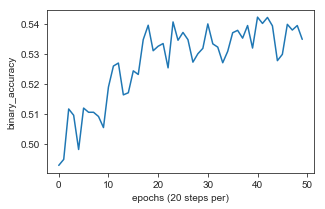

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)
history = train_model(
            optimizer,
            model_type='linear_hero_only',
            vocab_len=len(champ_vocab),
            embedding_dims=2,
            batch_size=500, 
            epochs=50, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

Train for 20 steps, validate for 20 steps
Epoch 1/50
20/20 [==============================] - 14s 721ms/step - loss: 1.4149 - binary_accuracy: 0.4949 - val_loss: 1.0623 - val_binary_accuracy: 0.4961
Epoch 2/50
20/20 [==============================] - 8s 386ms/step - loss: 0.9054 - binary_accuracy: 0.5019 - val_loss: 0.7896 - val_binary_accuracy: 0.4923
Epoch 3/50
20/20 [==============================] - 8s 415ms/step - loss: 0.7553 - binary_accuracy: 0.4909 - val_loss: 0.7241 - val_binary_accuracy: 0.5037
Epoch 4/50
20/20 [==============================] - 8s 413ms/step - loss: 0.7102 - binary_accuracy: 0.5067 - val_loss: 0.7049 - val_binary_accuracy: 0.5017
Epoch 5/50
20/20 [==============================] - 8s 412ms/step - loss: 0.6998 - binary_accuracy: 0.5067 - val_loss: 0.6991 - val_binary_accuracy: 0.5011
Epoch 6/50
20/20 [==============================] - 8s 397ms/step - loss: 0.6966 - binary_accuracy: 0.5096 - val_loss: 0.6973 - val_binary_accuracy: 0.5078
Epoch 7/50
20/20 [===

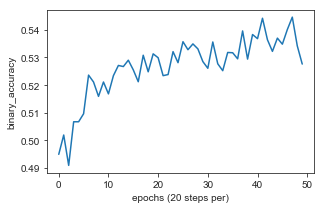

In [54]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.003)
history = train_model(
            optimizer,
            model_type='linear_extra_info',
            vocab_len=len(champ_vocab),
            embedding_dims=[4,4,4,4],#hero,info,tags,stats
            batch_size=500, 
            epochs=50, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

Train for 20 steps, validate for 20 steps
Epoch 1/40
20/20 [==============================] - 15s 725ms/step - loss: 1.1553 - binary_accuracy: 0.4944 - val_loss: 0.8919 - val_binary_accuracy: 0.5053
Epoch 2/40
20/20 [==============================] - 8s 382ms/step - loss: 0.8102 - binary_accuracy: 0.4951 - val_loss: 0.7438 - val_binary_accuracy: 0.5027
Epoch 3/40
20/20 [==============================] - 8s 382ms/step - loss: 0.7168 - binary_accuracy: 0.5099 - val_loss: 0.7094 - val_binary_accuracy: 0.5111
Epoch 4/40
20/20 [==============================] - 8s 379ms/step - loss: 0.7072 - binary_accuracy: 0.5091 - val_loss: 0.7019 - val_binary_accuracy: 0.5102
Epoch 5/40
20/20 [==============================] - 8s 399ms/step - loss: 0.6988 - binary_accuracy: 0.5211 - val_loss: 0.6976 - val_binary_accuracy: 0.5160
Epoch 6/40
20/20 [==============================] - 8s 390ms/step - loss: 0.6978 - binary_accuracy: 0.5109 - val_loss: 0.6962 - val_binary_accuracy: 0.5142
Epoch 7/40
20/20 [===

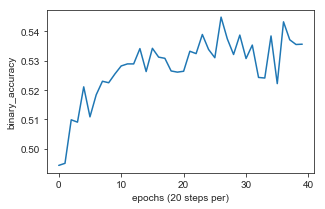

In [56]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.004)
history = train_model(
            optimizer,
            model_type='linear_extra_info',
            vocab_len=len(champ_vocab),
            embedding_dims=[3,3,3,3],#hero,info,tags,stats
            batch_size=500, 
            epochs=40, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

#### Linear and DNN but allowing hero order to matter

Model: "radiant_win"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
radiant_hero0 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero1 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero2 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero3 (InputLayer)      [(None, 1, 144)]     0                                            
________________________________________________________________________________________

Epoch 19/250
20/20 [==============================] - 9s 426ms/step - loss: 0.6928 - binary_accuracy: 0.5120 - val_loss: 0.6936 - val_binary_accuracy: 0.5088
Epoch 20/250
20/20 [==============================] - 10s 504ms/step - loss: 0.6932 - binary_accuracy: 0.5110 - val_loss: 0.6935 - val_binary_accuracy: 0.5119
Epoch 21/250
20/20 [==============================] - 8s 421ms/step - loss: 0.6937 - binary_accuracy: 0.5067 - val_loss: 0.6927 - val_binary_accuracy: 0.5179
Epoch 22/250
20/20 [==============================] - 8s 408ms/step - loss: 0.6931 - binary_accuracy: 0.5134 - val_loss: 0.6937 - val_binary_accuracy: 0.5124
Epoch 23/250
20/20 [==============================] - 8s 406ms/step - loss: 0.6920 - binary_accuracy: 0.5191 - val_loss: 0.6936 - val_binary_accuracy: 0.5119
Epoch 24/250
20/20 [==============================] - 8s 418ms/step - loss: 0.6921 - binary_accuracy: 0.5173 - val_loss: 0.6935 - val_binary_accuracy: 0.5100
Epoch 25/250
20/20 [==============================]

Epoch 71/250
20/20 [==============================] - 8s 417ms/step - loss: 0.6890 - binary_accuracy: 0.5351 - val_loss: 0.6913 - val_binary_accuracy: 0.5293
Epoch 72/250
20/20 [==============================] - 8s 417ms/step - loss: 0.6896 - binary_accuracy: 0.5372 - val_loss: 0.6922 - val_binary_accuracy: 0.5208
Epoch 73/250
20/20 [==============================] - 8s 399ms/step - loss: 0.6885 - binary_accuracy: 0.5461 - val_loss: 0.6921 - val_binary_accuracy: 0.5231
Epoch 74/250
20/20 [==============================] - 8s 404ms/step - loss: 0.6883 - binary_accuracy: 0.5455 - val_loss: 0.6918 - val_binary_accuracy: 0.5229
Epoch 75/250
20/20 [==============================] - 9s 435ms/step - loss: 0.6897 - binary_accuracy: 0.5328 - val_loss: 0.6910 - val_binary_accuracy: 0.5266
Epoch 76/250
20/20 [==============================] - 8s 414ms/step - loss: 0.6884 - binary_accuracy: 0.5355 - val_loss: 0.6917 - val_binary_accuracy: 0.5236
Epoch 77/250
20/20 [==============================] 

Epoch 123/250
20/20 [==============================] - 9s 447ms/step - loss: 0.6879 - binary_accuracy: 0.5404 - val_loss: 0.6914 - val_binary_accuracy: 0.5213
Epoch 124/250
20/20 [==============================] - 8s 390ms/step - loss: 0.6891 - binary_accuracy: 0.5302 - val_loss: 0.6912 - val_binary_accuracy: 0.5326
Epoch 125/250
20/20 [==============================] - 8s 388ms/step - loss: 0.6882 - binary_accuracy: 0.5410 - val_loss: 0.6915 - val_binary_accuracy: 0.5289
Epoch 126/250
20/20 [==============================] - 8s 396ms/step - loss: 0.6868 - binary_accuracy: 0.5477 - val_loss: 0.6909 - val_binary_accuracy: 0.5290
Epoch 127/250
20/20 [==============================] - 8s 377ms/step - loss: 0.6885 - binary_accuracy: 0.5387 - val_loss: 0.6914 - val_binary_accuracy: 0.5261
Epoch 128/250
20/20 [==============================] - 7s 374ms/step - loss: 0.6866 - binary_accuracy: 0.5521 - val_loss: 0.6909 - val_binary_accuracy: 0.5254
Epoch 129/250
20/20 [=========================

20/20 [==============================] - 8s 398ms/step - loss: 0.6876 - binary_accuracy: 0.5423 - val_loss: 0.6911 - val_binary_accuracy: 0.5284
Epoch 175/250
20/20 [==============================] - 8s 401ms/step - loss: 0.6874 - binary_accuracy: 0.5428 - val_loss: 0.6926 - val_binary_accuracy: 0.5227
Epoch 176/250
20/20 [==============================] - 9s 426ms/step - loss: 0.6869 - binary_accuracy: 0.5447 - val_loss: 0.6917 - val_binary_accuracy: 0.5259
Epoch 177/250
20/20 [==============================] - 8s 405ms/step - loss: 0.6873 - binary_accuracy: 0.5456 - val_loss: 0.6916 - val_binary_accuracy: 0.5287
Epoch 178/250
20/20 [==============================] - 8s 407ms/step - loss: 0.6867 - binary_accuracy: 0.5497 - val_loss: 0.6919 - val_binary_accuracy: 0.5261
Epoch 179/250
20/20 [==============================] - 8s 404ms/step - loss: 0.6877 - binary_accuracy: 0.5399 - val_loss: 0.6913 - val_binary_accuracy: 0.5290
Epoch 180/250
20/20 [==============================] - 8s 41

20/20 [==============================] - 9s 449ms/step - loss: 0.6874 - binary_accuracy: 0.5464 - val_loss: 0.6918 - val_binary_accuracy: 0.5281
Epoch 226/250
20/20 [==============================] - 9s 436ms/step - loss: 0.6877 - binary_accuracy: 0.5386 - val_loss: 0.6918 - val_binary_accuracy: 0.5259
Epoch 227/250
20/20 [==============================] - 8s 411ms/step - loss: 0.6864 - binary_accuracy: 0.5488 - val_loss: 0.6926 - val_binary_accuracy: 0.5182
Epoch 228/250
20/20 [==============================] - 9s 465ms/step - loss: 0.6871 - binary_accuracy: 0.5390 - val_loss: 0.6907 - val_binary_accuracy: 0.5330
Epoch 229/250
20/20 [==============================] - 10s 522ms/step - loss: 0.6864 - binary_accuracy: 0.5460 - val_loss: 0.6929 - val_binary_accuracy: 0.5219
Epoch 230/250
20/20 [==============================] - 9s 436ms/step - loss: 0.6871 - binary_accuracy: 0.5455 - val_loss: 0.6916 - val_binary_accuracy: 0.5267
Epoch 231/250
20/20 [==============================] - 9s 4

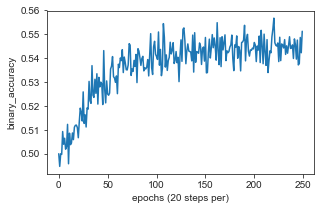

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
history = train_model(
            optimizer,
            model_type='linear_hero_only_ordermatters',
            vocab_len=len(champ_vocab),
            batch_size=500, 
            epochs=250, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

Model: "radiant_win"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
radiant_hero0 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero1 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero2 (InputLayer)      [(None, 1, 144)]     0                                            
__________________________________________________________________________________________________
radiant_hero3 (InputLayer)      [(None, 1, 144)]     0                                            
________________________________________________________________________________________

20/20 [==============================] - 7s 354ms/step - loss: 0.6930 - binary_accuracy: 0.5079 - val_loss: 0.6930 - val_binary_accuracy: 0.5055
Epoch 12/250
20/20 [==============================] - 7s 335ms/step - loss: 0.6929 - binary_accuracy: 0.5087 - val_loss: 0.6930 - val_binary_accuracy: 0.5038
Epoch 13/250
20/20 [==============================] - 7s 353ms/step - loss: 0.6929 - binary_accuracy: 0.5082 - val_loss: 0.6929 - val_binary_accuracy: 0.5110
Epoch 14/250
20/20 [==============================] - 6s 318ms/step - loss: 0.6930 - binary_accuracy: 0.5090 - val_loss: 0.6930 - val_binary_accuracy: 0.5114
Epoch 15/250
20/20 [==============================] - 7s 337ms/step - loss: 0.6930 - binary_accuracy: 0.5102 - val_loss: 0.6931 - val_binary_accuracy: 0.5057
Epoch 16/250
20/20 [==============================] - 7s 356ms/step - loss: 0.6929 - binary_accuracy: 0.5102 - val_loss: 0.6929 - val_binary_accuracy: 0.5048
Epoch 17/250
20/20 [==============================] - 7s 355ms/st

Epoch 63/250
20/20 [==============================] - 8s 377ms/step - loss: 0.6862 - binary_accuracy: 0.5493 - val_loss: 0.6920 - val_binary_accuracy: 0.5282
Epoch 64/250
20/20 [==============================] - 8s 414ms/step - loss: 0.6853 - binary_accuracy: 0.5624 - val_loss: 0.6927 - val_binary_accuracy: 0.5205
Epoch 65/250
20/20 [==============================] - 7s 360ms/step - loss: 0.6882 - binary_accuracy: 0.5456 - val_loss: 0.6932 - val_binary_accuracy: 0.5135
Epoch 66/250
20/20 [==============================] - 7s 355ms/step - loss: 0.6857 - binary_accuracy: 0.5593 - val_loss: 0.6939 - val_binary_accuracy: 0.5176
Epoch 67/250
20/20 [==============================] - 7s 328ms/step - loss: 0.6838 - binary_accuracy: 0.5667 - val_loss: 0.6928 - val_binary_accuracy: 0.5224
Epoch 68/250
20/20 [==============================] - 6s 312ms/step - loss: 0.6836 - binary_accuracy: 0.5629 - val_loss: 0.6938 - val_binary_accuracy: 0.5267
Epoch 69/250
20/20 [==============================] 

Epoch 115/250
20/20 [==============================] - 7s 367ms/step - loss: 0.6702 - binary_accuracy: 0.5979 - val_loss: 0.6985 - val_binary_accuracy: 0.5258
Epoch 116/250
20/20 [==============================] - 8s 410ms/step - loss: 0.6739 - binary_accuracy: 0.5870 - val_loss: 0.6964 - val_binary_accuracy: 0.5285
Epoch 117/250
20/20 [==============================] - 7s 351ms/step - loss: 0.6695 - binary_accuracy: 0.6057 - val_loss: 0.6996 - val_binary_accuracy: 0.5254
Epoch 118/250
20/20 [==============================] - 7s 336ms/step - loss: 0.6738 - binary_accuracy: 0.5888 - val_loss: 0.6974 - val_binary_accuracy: 0.5298
Epoch 119/250
20/20 [==============================] - 7s 349ms/step - loss: 0.6718 - binary_accuracy: 0.5964 - val_loss: 0.7022 - val_binary_accuracy: 0.5159
Epoch 120/250
20/20 [==============================] - 7s 349ms/step - loss: 0.6725 - binary_accuracy: 0.5940 - val_loss: 0.6991 - val_binary_accuracy: 0.5285
Epoch 121/250
20/20 [=========================

20/20 [==============================] - 7s 372ms/step - loss: 0.6541 - binary_accuracy: 0.6208 - val_loss: 0.7235 - val_binary_accuracy: 0.5166
Epoch 167/250
20/20 [==============================] - 7s 367ms/step - loss: 0.6522 - binary_accuracy: 0.6313 - val_loss: 0.7237 - val_binary_accuracy: 0.5163
Epoch 168/250
20/20 [==============================] - 7s 327ms/step - loss: 0.6553 - binary_accuracy: 0.6231 - val_loss: 0.7186 - val_binary_accuracy: 0.5170
Epoch 169/250
20/20 [==============================] - 6s 319ms/step - loss: 0.6533 - binary_accuracy: 0.6288 - val_loss: 0.7204 - val_binary_accuracy: 0.5133
Epoch 170/250
20/20 [==============================] - 7s 353ms/step - loss: 0.6494 - binary_accuracy: 0.6354 - val_loss: 0.7167 - val_binary_accuracy: 0.5167
Epoch 171/250
20/20 [==============================] - 7s 354ms/step - loss: 0.6532 - binary_accuracy: 0.6274 - val_loss: 0.7160 - val_binary_accuracy: 0.5189
Epoch 172/250
20/20 [==============================] - 7s 34

20/20 [==============================] - 7s 344ms/step - loss: 0.6438 - binary_accuracy: 0.6452 - val_loss: 0.7312 - val_binary_accuracy: 0.5214
Epoch 218/250
20/20 [==============================] - 7s 337ms/step - loss: 0.6406 - binary_accuracy: 0.6461 - val_loss: 0.7352 - val_binary_accuracy: 0.5137
Epoch 219/250
20/20 [==============================] - 7s 342ms/step - loss: 0.6324 - binary_accuracy: 0.6607 - val_loss: 0.7366 - val_binary_accuracy: 0.5145
Epoch 220/250
20/20 [==============================] - 7s 341ms/step - loss: 0.6355 - binary_accuracy: 0.6534 - val_loss: 0.7341 - val_binary_accuracy: 0.5157
Epoch 221/250
20/20 [==============================] - 7s 339ms/step - loss: 0.6255 - binary_accuracy: 0.6693 - val_loss: 0.7346 - val_binary_accuracy: 0.5206
Epoch 222/250
20/20 [==============================] - 7s 340ms/step - loss: 0.6346 - binary_accuracy: 0.6523 - val_loss: 0.7366 - val_binary_accuracy: 0.5210
Epoch 223/250
20/20 [==============================] - 7s 33

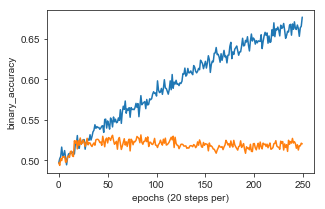

In [68]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005,amsgrad=True)
history = train_model(
            optimizer,
            model_type='dnn_hero_only_ordermatters',
            vocab_len=len(champ_vocab),
            batch_size=500, 
            epochs=250,
            hidden_units_out=[32,16,8,8,4,2],
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP')

#### DNN models

INFO:tensorflow:Assets written to: ../../../tmp_log_dir/lol_20200314-200821/saved_model/assets


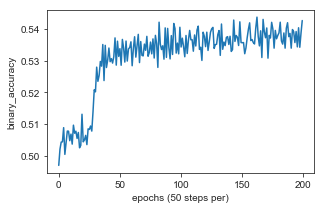

In [57]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
history = train_model(
            optimizer,
            model_type='dnn_hero_only',
            vocab_len=len(champ_vocab),
            embedding_dims=4,#hero
            batch_size=500, 
            epochs=200, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP',
            hidden_units_heroes=[4,4],
            hidden_units_out=[8,4,4])

Train for 20 steps, validate for 20 steps
Epoch 1/100
20/20 [==============================] - 11s 571ms/step - loss: 0.6954 - binary_accuracy: 0.5146 - val_loss: 0.6956 - val_binary_accuracy: 0.4985
Epoch 2/100
20/20 [==============================] - 6s 279ms/step - loss: 0.6942 - binary_accuracy: 0.5055 - val_loss: 0.6939 - val_binary_accuracy: 0.4956
Epoch 3/100
20/20 [==============================] - 5s 265ms/step - loss: 0.6937 - binary_accuracy: 0.5080 - val_loss: 0.6938 - val_binary_accuracy: 0.4887
Epoch 4/100
20/20 [==============================] - 6s 281ms/step - loss: 0.6932 - binary_accuracy: 0.5095 - val_loss: 0.6937 - val_binary_accuracy: 0.4948
Epoch 5/100
20/20 [==============================] - 5s 269ms/step - loss: 0.6935 - binary_accuracy: 0.5072 - val_loss: 0.6938 - val_binary_accuracy: 0.4954
Epoch 6/100
20/20 [==============================] - 5s 274ms/step - loss: 0.6932 - binary_accuracy: 0.5034 - val_loss: 0.6937 - val_binary_accuracy: 0.4934
Epoch 7/100
20/

20/20 [==============================] - 5s 259ms/step - loss: 0.6932 - binary_accuracy: 0.5020 - val_loss: 0.6933 - val_binary_accuracy: 0.4965
Epoch 53/100
20/20 [==============================] - 5s 257ms/step - loss: 0.6929 - binary_accuracy: 0.5140 - val_loss: 0.6933 - val_binary_accuracy: 0.5005
Epoch 54/100
20/20 [==============================] - 5s 258ms/step - loss: 0.6933 - binary_accuracy: 0.5014 - val_loss: 0.6932 - val_binary_accuracy: 0.5040
Epoch 55/100
20/20 [==============================] - 5s 256ms/step - loss: 0.6931 - binary_accuracy: 0.5034 - val_loss: 0.6931 - val_binary_accuracy: 0.5049
Epoch 56/100
20/20 [==============================] - 5s 263ms/step - loss: 0.6930 - binary_accuracy: 0.5083 - val_loss: 0.6931 - val_binary_accuracy: 0.5026
Epoch 57/100
20/20 [==============================] - 5s 274ms/step - loss: 0.6930 - binary_accuracy: 0.5074 - val_loss: 0.6932 - val_binary_accuracy: 0.4982
Epoch 58/100
20/20 [==============================] - 5s 262ms/st

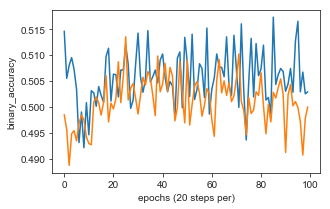

In [69]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,amsgrad=True)
history = train_model(
            optimizer,
            model_type='dnn_info_tags',
            vocab_len=len(champ_vocab),
            embedding_dims=[4,4,4],#hero,info,tags
            batch_size=500, 
            epochs=100, 
            training_path=training_file_novocab, 
            validation_path=validation_file_novocab,
            compression_type='GZIP',
            hidden_units_heroes=[8,4,4],
            hidden_units_out=[8,4,4])